In [1]:
import pandas as pd
import numpy as np

from importlib import reload

# import plotly
# import plotly.graph_objs as go
%matplotlib inline

In [2]:
import gameplan as gp
from gameplan.portfolio import Portfolio

In [3]:
misc = gp.expenses.Expense(
        expense_type='misc_spending',
        freq='M',
        amount=5000, 
        recurring=True,
        start_dt='2019-09-10', 
        growth_series=gp.growth_series.StochasticGrowth,
        growth_per_period_fn=lambda x: .02/12,
        growth_start_dt='2019-09-10', 
        growth_freq=pd.DateOffset(months=1),
        local_vol=0.10
    )

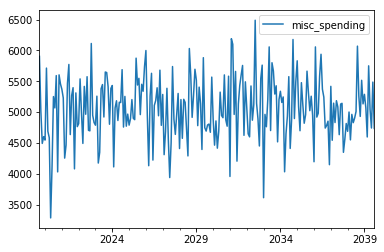

In [4]:
misc.cash_flows_df.plot()

In [5]:
r=gp.expenses.Rent(
    amount=2200, 
    start_dt='2019-09-01', 
    growth_start_dt='2020-01-01', 
    growth_freq=pd.DateOffset(years=1),
#     incorporate_discounting=False
)

/Users/davidbrodsky/.pyenv/versions/3.7.3/envs/db_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
r.growth_series.points_to_fit

[(0, 1), (1825, 1.75), (3650, 2.25)]

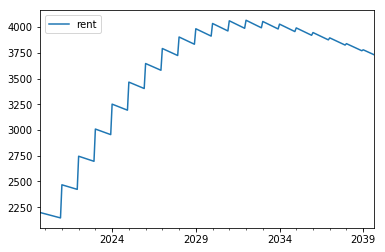

In [7]:
r.cash_flows_df.plot()

In [8]:
port = Portfolio(initial_cash_savings=200000, interest_rate=0.015)

In [9]:
s = gp.income_streams.Salary(
    paycheck_amt=180000/26, 
    payday_freq='2W-Fri', 
    tax_rate=0.375, 
    growth_start_dt='2019-10-22',
    incorporate_growth=True, 
    incorporate_discounting=True
)

existing_401k = gp.assets.Equity(init_value=45000)

/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:114: UserWarning: This Collection is empty.
  if warn: warnings.warn('This Collection is empty.')


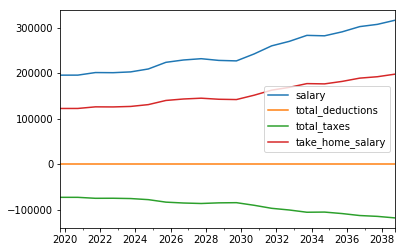

In [10]:
s.paycheck_df.resample('365d').sum().plot()

In [11]:
s.cash_flows_df.head()

,salary
2019-09-27,6923.076923
2019-10-11,6917.823966
2019-10-25,7323.805388
2019-11-08,7318.248373
2019-11-22,7312.695575


In [12]:
existing_401k.credits_and_debits.as_df

,initial_balance,total_net_cash_flow
2019-09-22,45000,45000


In [13]:
port.add_income_stream(s, label='salary', if_exists='overwrite')
port.add_asset(existing_401k, label='401k', if_exists='overwrite')

In [14]:
port.add_401k_contribution(
    income_stream_label='salary', 
    contrib_pct=0.06, 
    employer_match=dict(upto=0.04, pct_match=0.5),
    label='401k'
)

/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:114: UserWarning: This Collection is empty.
  if warn: warnings.warn('This Collection is empty.')


In [15]:
# need to incorporate growth here
port.add_pretax_expense(
    from_income_stream_label='salary',
    amt=180/2, 
    label='health_insurance',
    if_exists='overwrite'
)
port.add_pretax_expense('salary', label='HSA', amt=291.66/2, if_exists='overwrite')
port.add_pretax_expense('salary', label='travel', amt=127/2, if_exists='overwrite')

/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:43: UserWarning: Label 'cash_inflows' already exists. Will overwrite.
  warnings.warn(warning_message)


In [17]:
port.add_expense(
    expense=gp.expenses.Rent(
        amount=2200, 
        start_dt='2019-09-01', 
        min_growth=0.025, 
        max_growth=0.15, 
        growth_start_dt='2020-01-01', 
        growth_freq=pd.DateOffset(years=1)
    ),
    if_exists='overwrite'
)

#the path dependence here feels wrong; think about how to handle fluctuations that are random but mean(?) reverting
port.add_expense(
    expense=gp.expenses.Utilities(
        amount=130, 
        start_dt='2019-09-05', 
        min_growth= -0.05, 
        max_growth=0.052, 
        growth_start_dt='2019-09-05', 
        growth_freq=pd.DateOffset(months=1)
    ),
    if_exists='overwrite'
)

# Again, feels like this is stochastic growth w/ a trend 
port.add_expense(
    expense=gp.expenses.Expense(
        expense_type='misc_spending',
        freq='M',
        amount=5000, 
        recurring=True,
        start_dt='2019-09-10', 
        min_growth=-0.07, 
        max_growth=0.075, 
        growth_start_dt='2019-09-10', 
        growth_freq=pd.DateOffset(months=1)
    ),
    if_exists='overwrite'
)

/Users/davidbrodsky/.pyenv/versions/3.7.3/envs/db_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:43: UserWarning: Label 'cash_inflows' already exists. Will overwrite.
  warnings.warn(warning_message)
/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:43: UserWarning: Label 'cash_outflows' already exists. Will overwrite.
  warnings.warn(warning_message)


In [18]:
port.income_streams.contents['salary'].paycheck_df.tail()

,salary,total_deductions,total_taxes,take_home_salary
2039-07-22,12119.361926,-714.714615,-4276.742742,7127.904569
2039-08-05,12110.166233,-714.714615,-4273.294357,7122.157261
2039-08-19,12100.977517,-714.714615,-4269.848588,7116.414313
2039-09-02,12091.795773,-714.714615,-4266.405434,7110.675723
2039-09-16,12082.620996,-714.714615,-4262.964893,7104.941488


In [19]:
port.income_streams.contents['salary'].take_home_salary.resample('365D').sum().divide(12).multiply(0.33)

2019-09-27    3024.678493
2020-09-26    3037.771315
2021-09-26    3135.075213
2022-09-26    3129.881479
2023-09-26    3160.110176
2024-09-25    3270.059575
2025-09-25    3521.445375
2026-09-25    3609.889168
2027-09-25    3658.397099
2028-09-24    3593.788737
2029-09-24    3575.569168
2030-09-24    3836.680745
2031-09-24    4143.717128
2032-09-23    4312.968303
2033-09-23    4527.206680
2034-09-23    4522.715570
2035-09-23    4673.041552
2036-09-22    4870.730200
2037-09-22    4955.454807
2038-09-22    5110.966979
Freq: 365D, Name: take_home_salary, dtype: float64

# DB YOU ARE HERE

In [20]:
misc = gp.expenses.Expense(
        expense_type='misc_spending',
        freq='M',
        amount=5000, 
        recurring=True,
        start_dt='2019-09-10', 
        min_growth=-0.07, 
        max_growth=0.075, 
        growth_start_dt='2019-09-10', 
        growth_freq=pd.DateOffset(months=1)
    )

In [17]:
misc._get_growth_series()

2019-09-30    0.952297
2019-10-31    0.894789
2019-11-30    0.897009
2019-12-31    0.935273
2020-01-31    0.946047
2020-02-29    0.974907
2020-03-31    0.951042
2020-04-30    0.995285
2020-05-31    1.027519
2020-06-30    1.093650
2020-07-31    1.094928
2020-08-31    1.146592
2020-09-30    1.172906
2020-10-31    1.236208
2020-11-30    1.192303
2020-12-31    1.233026
2021-01-31    1.316201
2021-02-28    1.352440
2021-03-31    1.437731
2021-04-30    1.443521
2021-05-31    1.543531
2021-06-30    1.455594
2021-07-31    1.461212
2021-08-31    1.432577
2021-09-30    1.529252
2021-10-31    1.619819
2021-11-30    1.661613
2021-12-31    1.778501
2022-01-31    1.684416
2022-02-28    1.766403
                ...   
2037-03-31    3.897628
2037-04-30    4.002699
2037-05-31    3.894430
2037-06-30    4.027364
2037-07-31    3.792336
2037-08-31    4.004390
2037-09-30    3.757113
2037-10-31    3.763624
2037-11-30    3.853636
2037-12-31    3.808925
2038-01-31    3.556210
2038-02-28    3.355097
2038-03-31 

In [25]:
new_growth_fn = lambda x: 1 + (0.02/12)

In [ ]:
misc.get_growth_path()

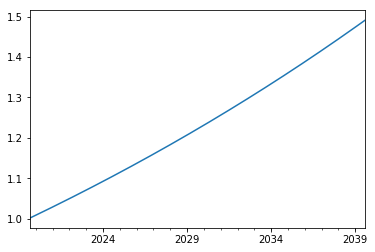

In [34]:
misc._get_growth_series(growth_fn=new_growth_fn).apply(lambda x: np.random.normal(x, scale=0.0)).plot()

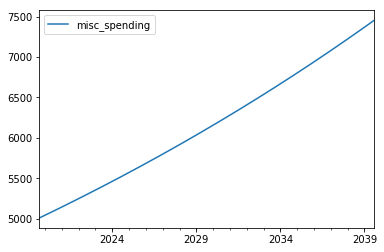

In [27]:
misc.cash_flows_df.plot()

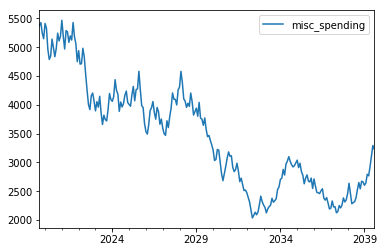

In [23]:
misc.cash_flows_df.plot()

In [16]:
initial_series.head(), initial_series.tail()

(2019-09-30    5000
 2019-10-31    5000
 2019-11-30    5000
 2019-12-31    5000
 2020-01-31    5000
 Freq: M, dtype: int64, 2039-04-30    5000
 2039-05-31    5000
 2039-06-30    5000
 2039-07-31    5000
 2039-08-31    5000
 Freq: M, dtype: int64)

In [17]:
growth_series.head(), growth_series.tail()

(2019-09-30    1.046652
 2019-10-31    1.119119
 2019-11-30    1.128280
 2019-12-31    1.097053
 2020-01-31    1.042787
 Freq: M, dtype: float64, 2039-04-30    1.205886
 2039-05-31    1.188739
 2039-06-30    1.260224
 2039-07-31    1.255398
 2039-08-31    1.347281
 Freq: M, dtype: float64)

In [50]:
misc.end_dt

Timestamp('2039-09-10 00:00:00')

In [49]:
misc.date_range

DatetimeIndex(['2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30',
               ...
               '2038-11-30', '2038-12-31', '2039-01-31', '2039-02-28',
               '2039-03-31', '2039-04-30', '2039-05-31', '2039-06-30',
               '2039-07-31', '2039-08-31'],
              dtype='datetime64[ns]', length=240, freq='M')

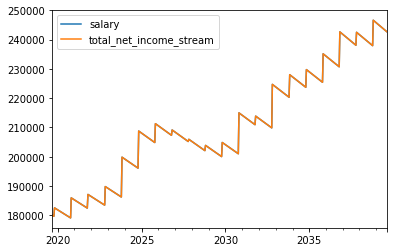

In [11]:
port.income_streams.as_df.multiply(26).plot()

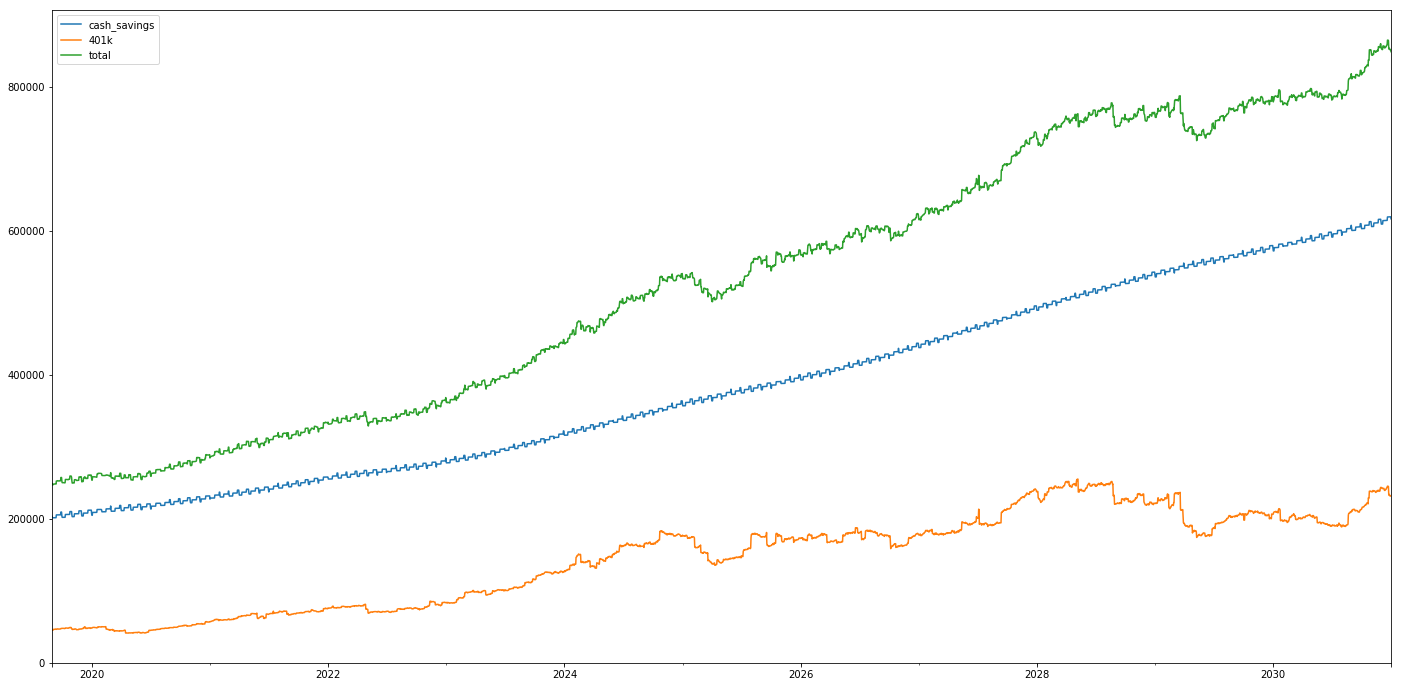

In [12]:
port.assets.generate_path_df()[:'2030'].plot(figsize=(24,12))

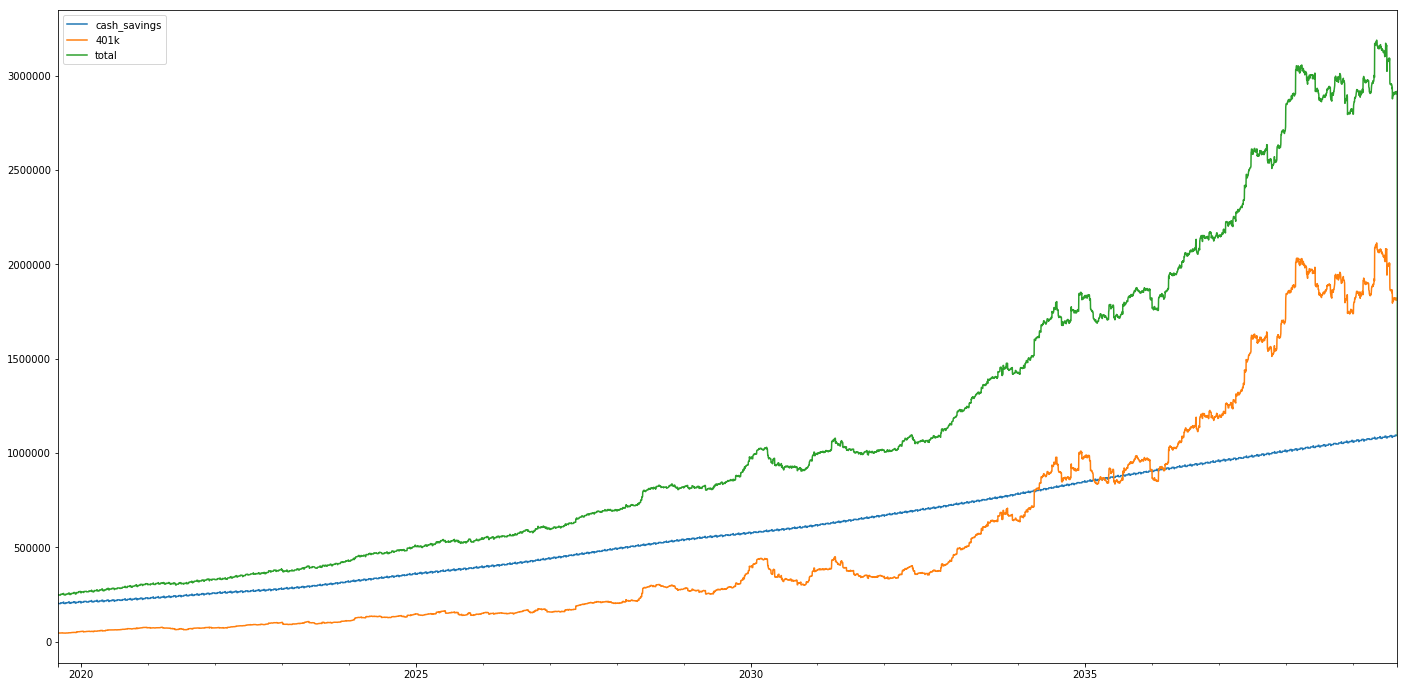

In [13]:
port.assets.generate_path_df().plot(figsize=(24,12))

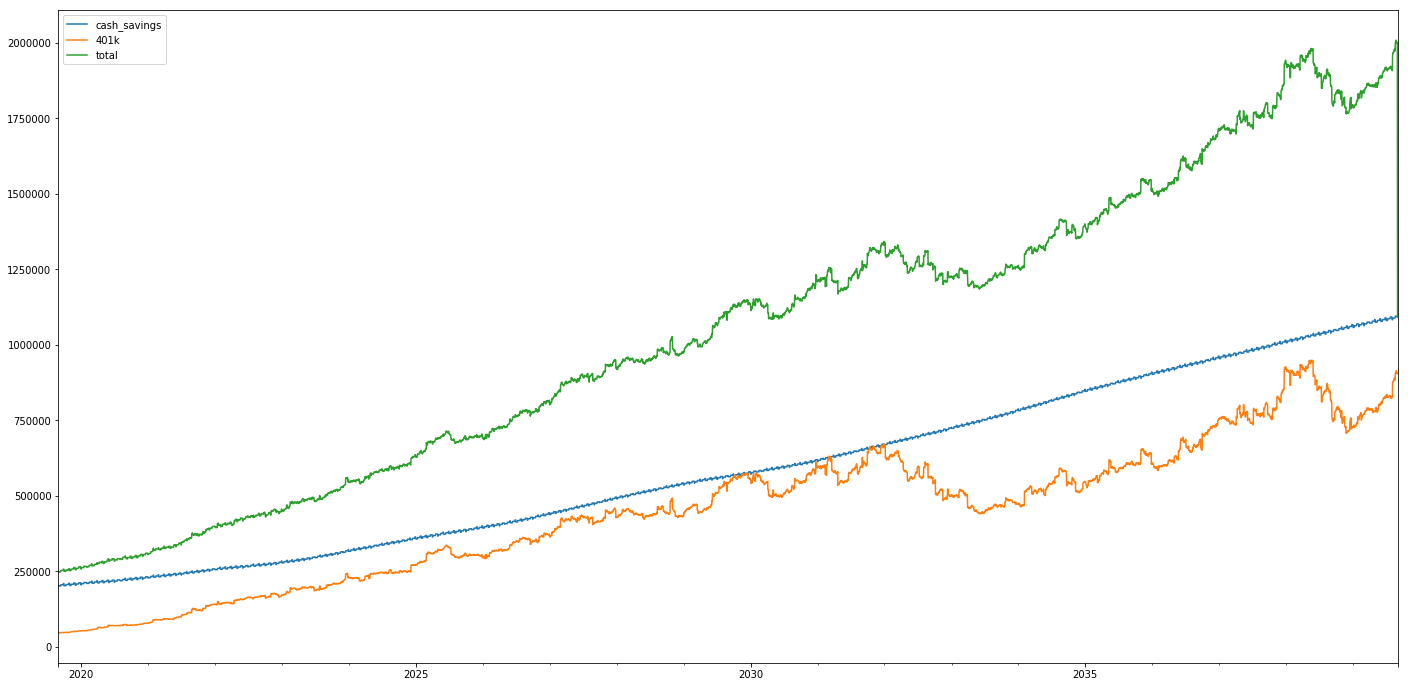

In [14]:
port.assets.generate_path_df().plot(figsize=(24,12))

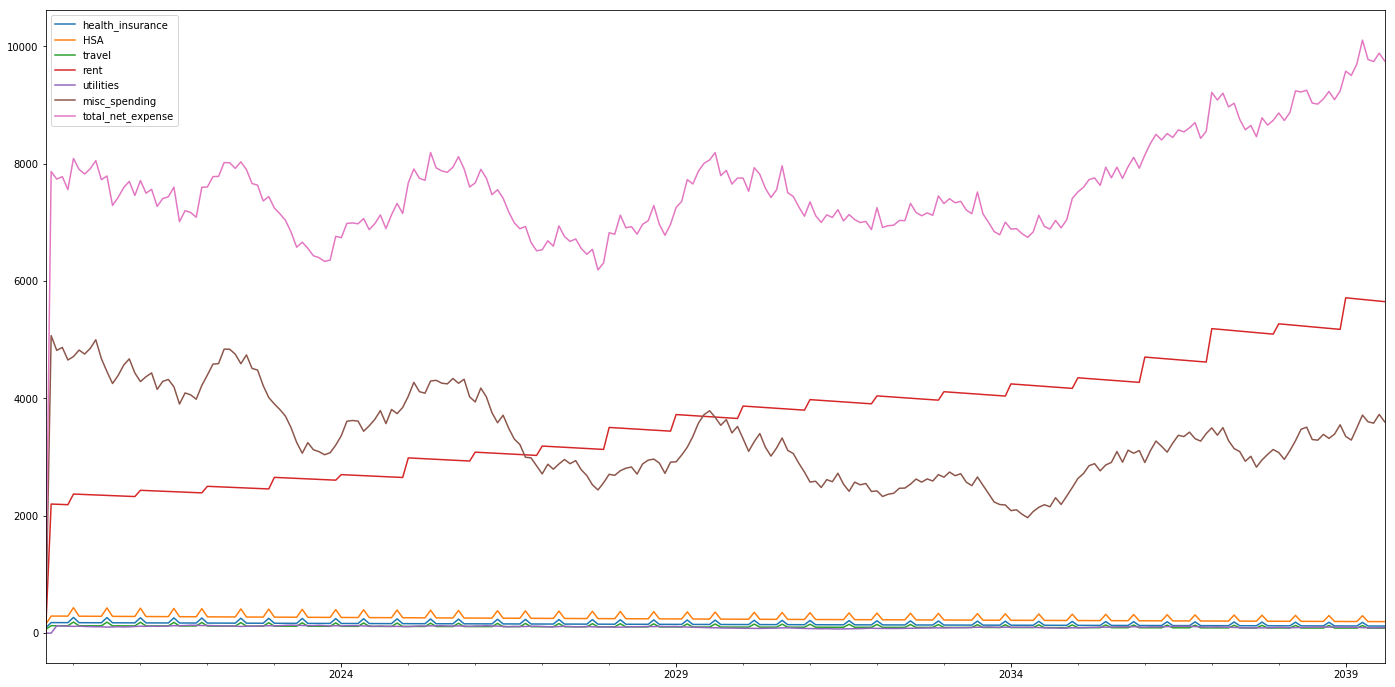

In [15]:
port.expenses.agg_cash_flows('M').multiply(-1).plot(figsize=(24,12))

In [18]:
port.all_cashflows

In [20]:
a = port.all_cashflows

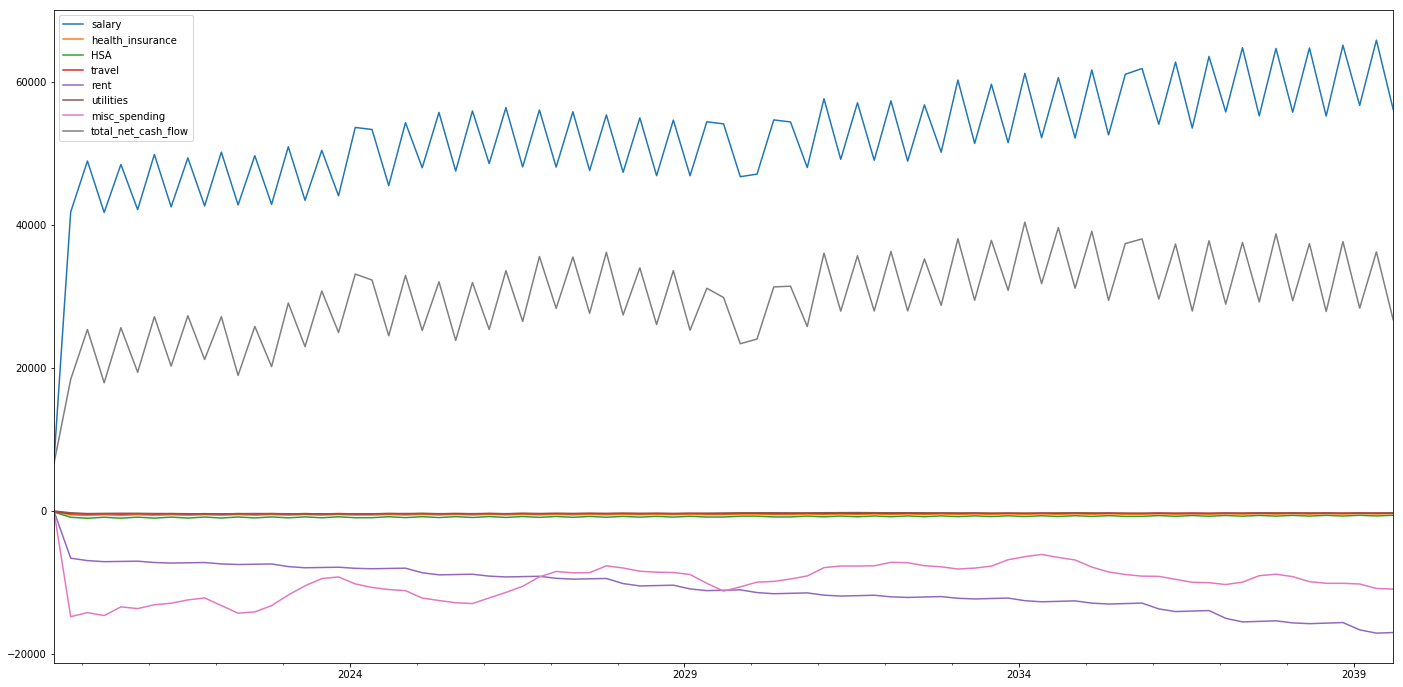

In [23]:
a.as_df.resample('3M').sum().plot(figsize=(24,12))

/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:43: UserWarning: Label 'cash_inflows' already exists. Will overwrite.
  warnings.warn(warning_message)
/Users/davidbrodsky/repos/gameplan/gameplan/collections.py:43: UserWarning: Label 'cash_outflows' already exists. Will overwrite.
  warnings.warn(warning_message)


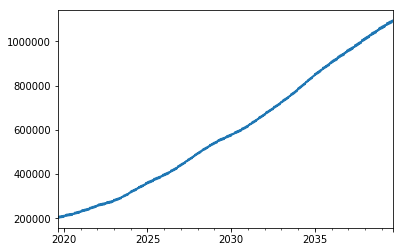

In [24]:
port.cash_savings.plot()

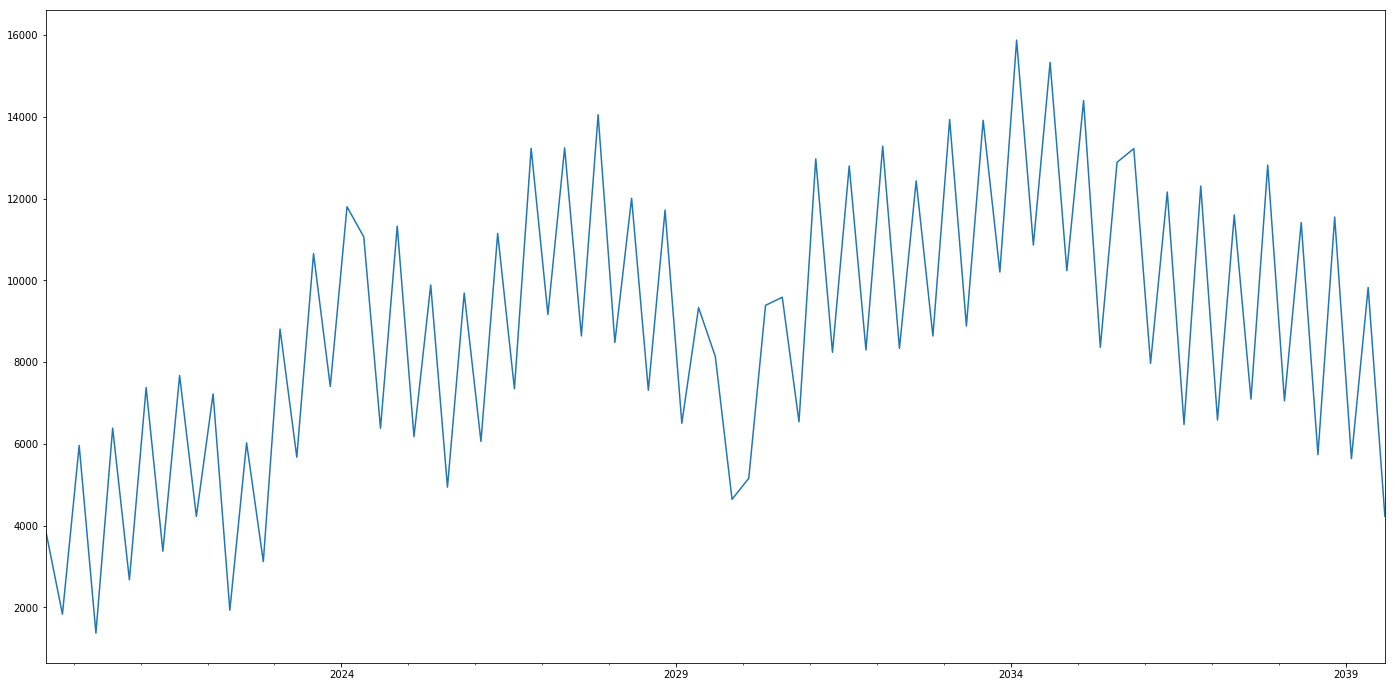

In [19]:
port.net_cashflows.resample('3M').sum().plot(figsize=(24,12))